In the [precedent notebook](https://github.com/CosmoStat/jax-lensing/blob/vi-in-progress/notebooks/point-estimate.ipynb), we recovered the convergence map as a point estimate through a simple gradient descent on the squared error reconstruction (based on the Kaiser-Squires transformation).

In this notebook, we aim to recover the convergence map $\kappa$ from the shear $\gamma$ as a **distrution over the pixels**, not only a point estimate.

As the Kaiser-Squires operators are not always invertible, we investigate different techniques to solve this inverse problem. Here, we supppose that we observe the shear $\gamma$ as the Kaise-Squires transformation of the convergence $\kappa$ comtaminated by an additive gaussian noise $n\sim \mathcal{N}(0, \bf{I})$ and maximize the posterior distribution $p(\kappa|\gamma) = \dfrac{p(\gamma, \kappa)}{\int p(\gamma, \kappa) d\kappa}$.

In this model, the precedent denominator is intractable to compute. Thus, we resort to *approximate posterior inference*, introducing a distribution over $\kappa$ that we simply suppose to be a **multivariate gaussian** with parameters $\nu = (\mu, \Sigma)$ such that $q(\kappa | \nu) \sim \mathcal{N}(\mu, \Sigma)$, that will approximate the posterior.

In variational inference, we aim to minimize the Kullback-Leibler (KL) divergence ("distance" for distrubutions) between the variational distribution $q(\kappa|\nu)$ and the posterior distribution $p(\kappa|\gamma)$.

$\begin{aligned}
\mathrm{KL}(q(\kappa|\nu)\|p(\kappa|\gamma)) &= \int q(\kappa|\nu) \log \dfrac{q(\kappa|\nu)}{p(\kappa|\gamma)} d\kappa \\
           &= \mathbb{E}_{\kappa \sim q(\kappa|\nu)}\left[\log q(\kappa|\nu)\right] - \mathbb{E}_{\kappa \sim q(\kappa|\nu)}\left[\log p(\kappa|\gamma)\right] \\
           &= \mathbb{E}_{\kappa \sim q(\kappa|\nu)}\left[\log q(\kappa|\nu)\right] - \mathbb{E}_{\kappa \sim q(\kappa|\nu)}\left[\log p(\kappa,\gamma)\right] + \log p(\gamma)\\
           &= - \mathrm{ELBO} + cte.
\end{aligned}$

The last term is considered as a constant (minimizing the KL divergence with respect to $\kappa$), and the opposite of the remaining terms is called the *evidence lower bound* (ELBO) which is a very studied function in variational inference. In the following, we aim to maximize the ELBO that we reformulate as the following:

$\begin{aligned}
\mathrm{ELBO} &= \mathbb{E}_{\kappa \sim q(\kappa|\nu)}\left[\log p(\kappa,\gamma)\right] - \mathbb{E}_{\kappa \sim q(\kappa|\nu)}\left[\log q(\kappa|\nu)\right] \\
              &= \mathbb{E}_{\kappa \sim q(\kappa|\nu)}\left[\log p(\gamma|\kappa)\right] + \mathbb{E}_{\kappa \sim q(\kappa|\nu)}\left[\log p(\kappa)\right] - \mathbb{E}_{\kappa \sim q(\kappa|\nu)}\left[\log q(\kappa|\nu)\right] \\
              &= \mathbb{E}_{\kappa \sim q(\kappa|\nu)}\left[\log p(\gamma|\kappa)\right] - \mathrm{KL}(q(\kappa|\nu)\|p(\kappa)).
\end{aligned}$

The last expression is the one implemented in the following. The idea is thus to maximize the likelihood of our reconstruction, regularized to have variational distribution not to much divergent from the prior distribution on $\kappa$. Here, the prior is supposed gaussian with zero mean and a standard deviation arroud 0.01 per pixel (deduced from observations of convergence maps).

In [3]:
from functools import partial
import matplotlib.pyplot as plt

import jax
from jax import jit, grad, vmap, value_and_grad
from jax import random
from jax.experimental import optimizers
import jax.numpy as jnp

from jax_lensing.inversion import ks93inv

from lenspack.peaks import find_peaks2d
from lenspack.utils import bin2d

from astropy.table import Table

import tensorflow_probability as tfp; tfp = tfp.experimental.substrates.jax

tfd = tfp.distributions

In [4]:
def plot_convergence(kappaE, x, y, title=''):
    # Plot peak positions over the convergence

    mappable = plt.imshow(kappaE, origin='lower', cmap='bone')
    plt.scatter(y, x, s=10, c='orange')  # reverse x and y due to array indexing
    plt.axis('off')
    plt.colorbar(mappable)
    plt.title(title)

In [5]:
# Import the galaxy catalog
cat = Table.read('../data/gal_cat.fits')
# Bin ellipticity components based on galaxy position into a 128 x 128 map
e1map, e2map = bin2d(cat['ra'], cat['dec'], v=(-cat['gamma1'], -cat['gamma2']), npix=128)

In [6]:
# Mask the shear images to simulate missing data and observe how the model react
mask1, mask2 = jnp.ones(e1map.shape), jnp.ones(e2map.shape)
mask1 = jax.ops.index_update(mask1, jax.ops.index[59:70, 59:70], 0.)
mask2 = jax.ops.index_update(mask2, jax.ops.index[59:70, 59:70], 0.)

e1map = mask1 * e1map
e2map = mask2 * e2map

/Users/br263581/opt/anaconda3/envs/cosmo/lib/python3.7/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


Visualize the inputs data (shear maps $\gamma$). Missing data have zero values.

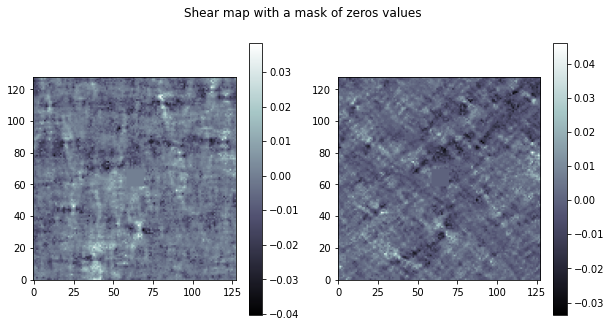

In [7]:
fig = plt.figure(figsize=(10, 5))
fig.suptitle('Shear map with a mask of zeros values')
plt.subplot(121)
plt.imshow(e1map*mask1, origin='lower', cmap='bone')
plt.colorbar()
plt.subplot(122)
plt.imshow(e2map*mask2, origin='lower', cmap='bone')
plt.colorbar()
#plt.savefig('./images/shear.png')
plt.show()

In [8]:
# ========= Functions to define the evidence lower bound. =========

def diag_gaussian_sample(rng, mean, log_std):
    # Take a single sample from a diagonal multivariate Gaussian.
    return tfd.MultivariateNormalDiag(mean, jnp.exp(log_std)).sample(seed=rng)

# ========= Define the log-likelihood =========

def log_likelihood(z):
    x = jnp.stack([e1map,e2map], axis=0).flatten()

    z1, z2 = z[:z.shape[0]//2], z[z.shape[0]//2:]

    kE, kB = jnp.reshape(z1, (128, 128)), jnp.reshape(z2, (128, 128))
    gamma1, gamma2 = ks93inv(kE, kB)
    gamma1 = mask1 * gamma1
    gamma2 = mask2 * gamma2

    mean = jnp.stack([gamma1,gamma2], axis=0).flatten()
    dist = tfd.MultivariateNormalDiag(mean, jnp.ones(mean.shape))
    
    return dist.log_prob(x)

In [9]:
# ========= Compute the KL divergence between to Multivariate gaussian distrib. =========

def gaussian_kl(mean, log_std):
    q = tfd.MultivariateNormalDiag(mean, jnp.exp(log_std)) # approximate distribution
    p = tfd.MultivariateNormalDiag(jnp.zeros(mean.shape), 0.01*jnp.ones(mean.shape)) # prior
    return q.kl_divergence(p)

# ========= Define the Evidence lower bound =========

def elbo(logprob, rng, mean, log_std):
    # Single-sample Monte Carlo estimate of the variational lower bound.
    sample = diag_gaussian_sample(rng, mean, log_std)
    return  logprob(sample) #- gaussian_kl(mean, log_std)

def batch_elbo(logprob, rng, params, num_samples):
    # Average over a batch of random samples.
    rngs = random.split(rng, num_samples)
    vectorized_elbo = jit(vmap(partial(elbo, logprob), in_axes=(0, None, None)))
    return jnp.mean(vectorized_elbo(rngs, *params))

In [10]:
num_samples = 1 # batch size ?

@jit
def objective(params, t):
    rng = random.PRNGKey(t)
    return -batch_elbo(log_likelihood, rng, params, num_samples)

# Set up optimizer.
D = 2 * e1map.shape[0] * e1map.shape[1]

init_mean = jnp.zeros(D)
init_log_std  = jnp.ones(D)
init_params = (init_mean, init_log_std)
opt_init, opt_update, get_params = optimizers.sgd(1e-3)#optimizers.adam(1e-4)#
opt_state = opt_init(init_params)

@jit
def update(i, opt_state):
    params = get_params(opt_state)
    loss, gradient = value_and_grad(objective)(params, i)
    return loss, opt_update(i, gradient, opt_state)

elbo_list = []

# Main loop.
print("Optimizing variational parameters...")

for t in range(10000):
    loss, opt_state = update(t, opt_state)
    params = get_params(opt_state)
    elbo_list.append(-loss)

    if t%1000==0:
        print('step', t)

Optimizing variational parameters...
Instructions for updating:
Do not pass `graph_parents`.  They will  no longer be used.


Instructions for updating:
Do not pass `graph_parents`.  They will  no longer be used.
/Users/br263581/opt/anaconda3/envs/cosmo/lib/python3.7/site-packages/jax/numpy/lax_numpy.py:1601: FutureWarning: jax.numpy reductions won't accept lists and tuples in future versions, only scalars and ndarrays
  warnings.warn(msg, category=FutureWarning)


step 0
step 1000
step 2000
step 3000
step 4000
step 5000
step 6000
step 7000
step 8000
step 9000


In [11]:
kappa = params[0]
kE, kB = kappa[:kappa.shape[0]//2], kappa[kappa.shape[0]//2:]
kE, kB = jnp.reshape(kE, (128, 128)), jnp.reshape(kB, (128, 128))

Visualize the recovered convergence map in E and B modes.

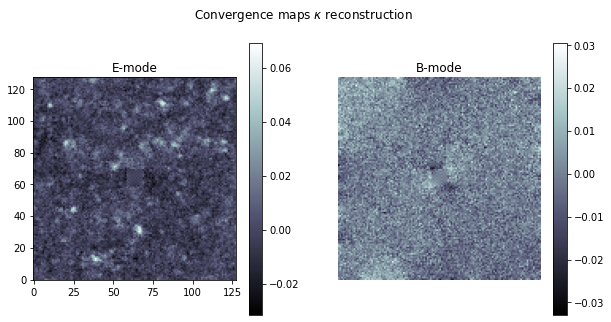

In [12]:
#x, y, h = find_peaks2d(kE, threshold=0.03, include_border=True)
# Plot peak positions over the convergence
fig = plt.figure(figsize=(10, 5))
fig.suptitle('Convergence maps $\kappa$ reconstruction')
plt.subplot(121)
#plot_convergence(kE, x, y)#, title='$\kappa_E$ via Variatinal Inference')
plt.imshow(kE, origin='lower', cmap='bone')
plt.colorbar()
plt.title('E-mode')
plt.subplot(122)
plt.imshow(kB, origin='lower', cmap='bone')
plt.title('B-mode')
plt.axis('off')
plt.colorbar()
#plt.savefig('./images/convergence.png')

plt.show()

Since we have a gaussian distribution for every pixels, we can visualize their standard deviation and notably for the ones corresponding to missing data where we can see that the uncertainity goes up.

pixels gaussian standard deviation along a line over the mask
[0.22595994 0.22815478 0.22558957 0.22978918 0.2256354  0.2844597
 0.34895286 0.7620815  0.8702194  0.9683621  1.0240636  1.0125334
 1.0037913  0.9706845  0.877634   0.7531603  0.35029963 0.28485215
 0.22701572 0.22594793 0.22639762 0.22759524 0.2227182 ]


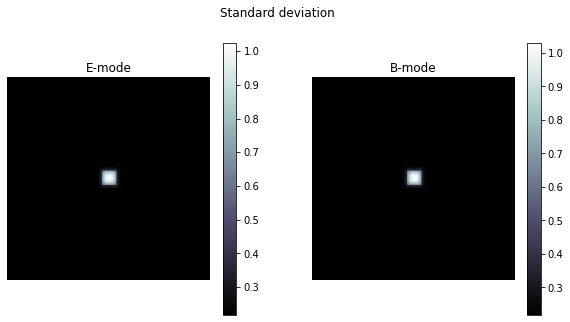

In [13]:
# Visualize the standard deviation
std = jnp.exp(params[1])
stdE, stdB = std[:std.shape[0]//2], std[std.shape[0]//2:]
stdE, stdB = jnp.reshape(stdE, (128, 128)), jnp.reshape(stdB, (128, 128))

fig = plt.figure(figsize=(10, 5))
fig.suptitle('Standard deviation')
plt.subplot(121)
plt.imshow(stdE, origin='lower', cmap='bone')
plt.title('E-mode')
plt.axis('off')
plt.colorbar()

plt.subplot(122)
plt.imshow(stdB, origin='lower', cmap='bone')
plt.title('B-mode')
plt.axis('off')
plt.colorbar()

#plt.savefig('./images/std.png')

print('pixels gaussian standard deviation along a line over the mask')
print(stdE[53:76, 64])

Convergence of the evidence lower bound.

Text(0.5, 0, 'steps')

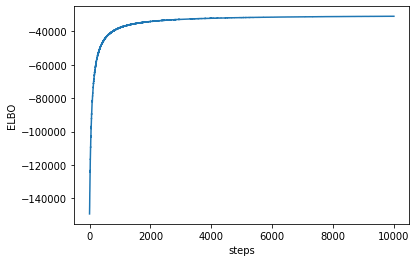

In [14]:
plt.plot(elbo_list)
plt.ylabel('ELBO')
plt.xlabel('steps')
#plt.savefig('./images/elbo.png')

In [17]:
jnp.save('../data/convergence_vi.npy', jnp.stack([params[0], params[1]]).shape)

(2, 32768)